In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
# import data_creation_pipeline as dcp
# import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-09-05 06:57:00.945992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 06:57:03.005986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 06:57:03.014491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 06:57:24.322779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-05 06:57:54.948495: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
idx_LH_str = '0663'
sim_name_quijote = f'quijote_LH{idx_LH_str}'

dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
fn_params = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
param_dict['tau'] = 0.0952 # ?? TODO check proper tau to be using!! 
cosmo_quijote = utils.get_cosmo(param_dict)

Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


In [3]:
box_size = 1000.

## Make LR simulation, bias model

In [4]:
n_grid = 512

ngenic_phases = True
phase_type = 1

seed = int(idx_LH_str)
expfactor = 1.0
FixedInitialAmplitude = False

sim_2lpt, disp_2lpt = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-09-05 06:58:20,036 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-09-05 06:58:20,037 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-09-05 06:58:20,038 bacco.sims : Initialising simulation Default
2024-09-05 06:58:20,039 bacco.sims : ...done in 0.00171 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2024-09-05 06:58:46,936 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [5]:
dens_lin_2lpt = sim_2lpt.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


In [6]:
bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", 
                        BoxSize=box_size,
                        npart_for_fake_sim=n_grid, 
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=False,
                        )

2024-09-05 06:58:54,793 bacco.BiasModel : Initialising Bias Model class ...


In [7]:
bias_fields_lag = bmodel.bias_terms_lag()

2024-09-05 06:58:58,493 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-09-05 06:58:58,494 bacco.BiasModel : fttw plan
2024-09-05 06:58:58,495 bacco.BiasModel : Computing linear field ...
2024-09-05 06:58:58,496 bacco.BiasModel : Memory used: 7.50864384 Gigabytes
2024-09-05 06:58:58,522 bacco.BiasModel : fttw freqs
2024-09-05 06:58:58,522 bacco.BiasModel : tidk freqs
2024-09-05 07:00:57,236 bacco.BiasModel : ifft
2024-09-05 07:01:40,041 bacco.BiasModel : Computing laplacian ...
2024-09-05 07:01:40,044 bacco.BiasModel : Memory used: 17.190825984 Gigabytes
2024-09-05 07:05:20,644 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-09-05 07:05:20,648 bacco.BiasModel : Memory used: 18.258587648 Gigabytes
2024-09-05 07:05:20,891 bacco.BiasModel : Computing delta squared ...
2024-09-05 07:05:20,893 bacco.BiasModel : Memory used: 18.795393024 Gigabytes
2024-09-05 07:05:23,395 bacco.BiasModel : Computing tidal component G2 with the given tidal field
20

In [8]:
import readgadget

snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [9]:
idx_LH = '663'
fn_lag_index = f"/cosmos_storage/data_sharing/quijote_{idx_LH}_neighfile.pickle"
with open(fn_lag_index, 'rb') as f:
    lag_index = pickle.load(f)
print(lag_index.shape)

(134217728,)


In [10]:
pos_LR = pos_raw[lag_index]

In [11]:
bias_terms_eul_LR =[]
for ii in range(0,len(bias_fields_lag)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_LR, 
                            mass = (bias_fields_lag[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul_LR.append(bias_terms)
bias_terms_eul_LR = np.array(bias_terms_eul_LR)

2024-09-05 07:06:11,760 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:06:12,176 bacco.statistics : starting deposit 1
2024-09-05 07:06:13,395 bacco.statistics :  mesh done in 1.64 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:06:14,734 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:06:15,141 bacco.statistics : starting deposit 1
2024-09-05 07:06:16,004 bacco.statistics :  mesh done in 1.27 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:06:17,297 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:06:17,707 bacco.statistics : starting deposit 1
2024-09-05 07:06:18,582 bacco.statistics :  mesh done in 1.29 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:06:19,909 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:06:20,450 bacco.statistics : starting deposit 1
2024-09-05 07:06:21,335 bacco.statistics :  mesh done in 1.43 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:06:22,678 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:06:23,084 bacco.statistics : starting deposit 1
2024-09-05 07:06:24,028 bacco.statistics :  mesh done in 1.35 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


## Same for HR, but dilute it to be same grid size

In [12]:
n_grid_HR = 1024

ngenic_phases = True
phase_type = 1

seed = int(idx_LH_str)
expfactor = 1.0
FixedInitialAmplitude = False

sim_2lpt_HRdil, disp_2lpt_HRdil = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-09-05 07:06:29,204 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-09-05 07:06:29,206 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-09-05 07:06:29,207 bacco.sims : Initialising simulation Default
2024-09-05 07:06:29,208 bacco.sims : ...done in 0.00192 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2024-09-05 07:06:56,180 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [13]:
dens_lin_2lpt_HRdil = sim_2lpt_HRdil.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


In [14]:
bmodel_HRdil = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt_HRdil, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", 
                        BoxSize=box_size,
                        npart_for_fake_sim=n_grid, 
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=False,
                        )

2024-09-05 07:07:04,563 bacco.BiasModel : Initialising Bias Model class ...


In [15]:
bias_fields_lag_HRdil = bmodel_HRdil.bias_terms_lag()

2024-09-05 07:07:08,749 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-09-05 07:07:08,750 bacco.BiasModel : fttw plan
2024-09-05 07:07:08,751 bacco.BiasModel : Computing linear field ...
2024-09-05 07:07:08,753 bacco.BiasModel : Memory used: 27.933560832 Gigabytes
2024-09-05 07:07:08,768 bacco.BiasModel : fttw freqs
2024-09-05 07:07:08,769 bacco.BiasModel : tidk freqs
2024-09-05 07:09:04,091 bacco.BiasModel : ifft
2024-09-05 07:09:46,244 bacco.BiasModel : Computing laplacian ...
2024-09-05 07:09:46,247 bacco.BiasModel : Memory used: 37.603762176 Gigabytes
2024-09-05 07:13:28,101 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-09-05 07:13:28,104 bacco.BiasModel : Memory used: 38.671634432 Gigabytes
2024-09-05 07:13:28,364 bacco.BiasModel : Computing delta squared ...
2024-09-05 07:13:28,366 bacco.BiasModel : Memory used: 39.208370176 Gigabytes
2024-09-05 07:13:30,821 bacco.BiasModel : Computing tidal component G2 with the given tidal field


In [16]:
import readgadget

snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube_HR/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw_HR = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids_HR = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [17]:
idx_LH = '663'
fn_lag_index_HR = f"/cosmos_storage/data_sharing/quijote_{idx_LH}_HR_neighfile.pickle"
with open(fn_lag_index_HR, 'rb') as f:
    lag_index_HR = pickle.load(f)
print(lag_index_HR.shape)

(1073741824,)


In [18]:
pos_HR = pos_raw_HR[lag_index_HR]

In [19]:
pos_grid = pos_HR.reshape(n_grid_HR, n_grid_HR, n_grid_HR,3)

ndilution = 2
# _lag_index_HR = lag_index_HR.reshape(n_grid_HR,n_grid_HR, n_grid_HR)
# _lag_index_HR = lag_index_HR[::ndilution,::ndilution,::ndilution]
spos = pos_grid[::ndilution,::ndilution,::ndilution,:]
    
assert n_grid==n_grid_HR//ndilution
pos_HR_diluted = spos.reshape(n_grid**3, 3)
print(len(pos_HR_diluted))

134217728


In [20]:
bias_terms_eul_HRdil =[]
for ii in range(0,len(bias_fields_lag_HRdil)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_HR_diluted, 
                            mass = (bias_fields_lag_HRdil[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul_HRdil.append(bias_terms)
bias_terms_eul_HRdil = np.array(bias_terms_eul_HRdil)

2024-09-05 07:15:50,956 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:15:51,343 bacco.statistics : starting deposit 1
2024-09-05 07:15:52,579 bacco.statistics :  mesh done in 1.62 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:15:53,776 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:15:54,139 bacco.statistics : starting deposit 1
2024-09-05 07:15:55,017 bacco.statistics :  mesh done in 1.24 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:15:56,129 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:15:56,497 bacco.statistics : starting deposit 1
2024-09-05 07:15:57,370 bacco.statistics :  mesh done in 1.24 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:15:58,590 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:15:58,978 bacco.statistics : starting deposit 1
2024-09-05 07:15:59,850 bacco.statistics :  mesh done in 1.26 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-05 07:16:01,152 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-05 07:16:01,542 bacco.statistics : starting deposit 1
2024-09-05 07:16:02,414 bacco.statistics :  mesh done in 1.26 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


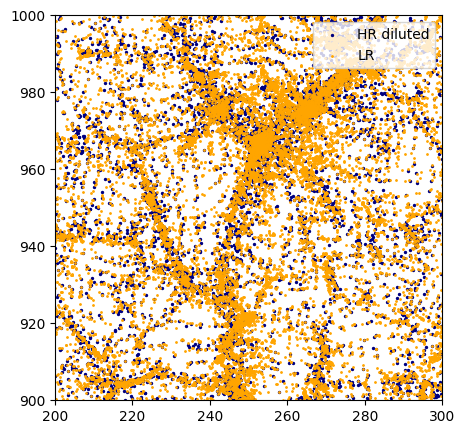

In [21]:
plt.figure(figsize=(5,5))
mask = (pos_HR_diluted[:,2] < 752) & (pos_HR_diluted[:,2] > 747) 
mask_LR = (pos_LR[:,2] < 755) & (pos_LR[:,2] > 745) 

plt.scatter(pos_HR_diluted[mask,0], pos_HR_diluted[mask,1],marker='o',s=2, color='navy', 
            label="HR diluted")
plt.scatter(pos_LR[mask_LR,0], pos_LR[mask_LR,1],marker='o',s=1, color='orange',
            label='LR')
plt.xlim([200,300]); plt.ylim([900,1000])
#plt.xlim([0,50]); plt.ylim([0,50])

plt.legend(loc='upper right')

In [22]:
dx_density = (bias_terms_eul_HRdil[1][0,:,:,:]-bias_terms_eul_LR[1][0,:,:,:]).flatten()

In [23]:
# fig, ax = plt.subplots(1,3, figsize=(10,4))
# labels = ['x', 'y', 'z']
# for axis in range(3):
#     ax[axis].hist(dx_density[:,axis],ls=':',#range=[-20,20], 
#                   bins=30)
#     ax.set_xlabel(rf'{labels[axis]}_\text{{HR,diluted}} - {labels[axis]}_\text{{LR}}')
    

Text(0, 0.5, '$\\langle \\delta \\delta \\rangle_\\text{HR-diluted} - \\langle \\delta \\delta \\rangle_\\text{LR}$')

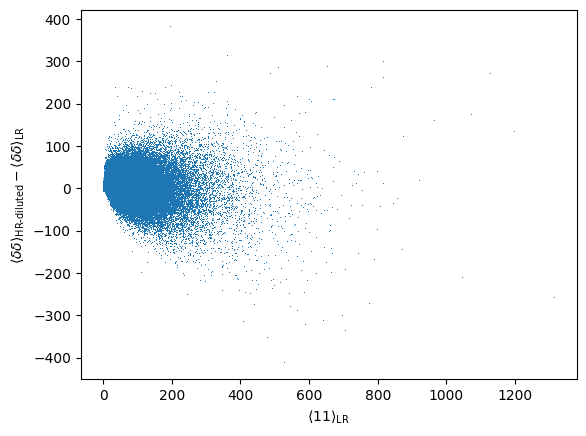

In [59]:
plt.plot(bias_terms_eul_LR[0].flatten(),dx_density,',')
plt.xlabel(r'$\langle 11 \rangle_\text{LR}$')
plt.ylabel(r'$\langle \delta \delta \rangle_\text{HR-diluted} - \langle \delta \delta \rangle_\text{LR}$')

### Compare power spectra

In [25]:
lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=30)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_quijote, expfactor=cosmo_quijote.expfactor, wavemode=lt_k)

In [27]:
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = False

args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

In [41]:
#Compute the P(k) of the 15 terms
import itertools

prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_LR.shape[0]),r=2)))
is_pnn_subset = [0,1,5]

bias_terms_eul_norm = bias_terms_eul_LR/n_grid**3
power_all_terms_LR = []
for ii in range(0,len(prod)):
    if ii not in is_pnn_subset:
        power_all_terms_LR.append(None)
        continue
    
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power_grid_ii = args_power_grid.copy()
    #args_power_grid_ii['correct_grid'] = False if ii == 11 else True
    args_power_grid_ii['correct_grid'] = True #TRYING
    print(prod[ii]) 
    power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm[prod[ii,1]],
                                                    ngrid=n_grid,
                                                    cosmology=cosmo_quijote,
                                                    box=box_size,
                                                    **args_power_grid_ii)
    power_all_terms_LR.append(power_term)

2024-09-05 08:03:17,420 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.051077 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.573640 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


2024-09-05 08:03:25,393 bacco.statistics :  ...done in 7.97 s
2024-09-05 08:03:25,395 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.02861e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.082296 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.571340 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000159 secs
bacco.power : Deallocating arrays


2024-09-05 08:03:34,831 bacco.statistics :  ...done in 9.44 s
2024-09-05 08:03:34,833 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.02861e-10 (grid1) -1.02861e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.316036 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.573623 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


2024-09-05 08:03:44,663 bacco.statistics :  ...done in 9.83 s


In [31]:
pk_obj_delta_LR = bacco.statistics.compute_crossspectrum_twogrids(
                grid1=bias_fields_lag[1]/n_grid**3,
                grid2=bias_fields_lag[1]/n_grid**3,
                cosmology=cosmo_quijote,
                ngrid=n_grid,
                box=box_size,
                # normalise_grid1=normalise_grid,
                # normalise_grid2=normalise_grid,
                # deconvolve_grid1=deconvolve_grid,
                # deconvolve_grid2=deconvolve_grid,
                **args_power_grid)


2024-09-05 07:53:59,839 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.92049e-11 (grid1) 3.92049e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.280578 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.573111 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000156 secs
bacco.power : Deallocating arrays


2024-09-05 07:54:09,384 bacco.statistics :  ...done in 9.55 s


HR:

In [43]:
#Compute the P(k) of the 15 terms
import itertools

prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_HRdil.shape[0]),r=2)))
is_pnn_subset = [0,1,5]

bias_terms_eul_norm = bias_terms_eul_HRdil/n_grid**3
power_all_terms_HRdil = []
for ii in range(0,len(prod)):
    if ii not in is_pnn_subset:
        power_all_terms_HRdil.append(None)
        continue
    
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power_grid_ii = args_power_grid.copy()
    #args_power_grid_ii['correct_grid'] = False if ii == 11 else True
    args_power_grid_ii['correct_grid'] = True # changed to this
    print(prod[ii])
    power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm[prod[ii,1]],
                                                    ngrid=n_grid,
                                                    cosmology=cosmo_quijote,
                                                    box=box_size,
                                                    **args_power_grid_ii)
    power_all_terms_HRdil.append(power_term)

2024-09-05 08:05:23,451 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.003251 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.580722 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


2024-09-05 08:05:30,458 bacco.statistics :  ...done in 7.01 s
2024-09-05 08:05:30,459 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.27469e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.083831 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.589010 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000144 secs
bacco.power : Deallocating arrays


2024-09-05 08:05:37,464 bacco.statistics :  ...done in 7.01 s
2024-09-05 08:05:37,465 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.27469e-10 (grid1) -1.27469e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.992277 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.577333 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000155 secs
bacco.power : Deallocating arrays


2024-09-05 08:05:44,195 bacco.statistics :  ...done in 6.73 s


In [34]:
pk_obj_delta_HRdil = bacco.statistics.compute_crossspectrum_twogrids(
                grid1=bias_fields_lag_HRdil[1]/n_grid**3,
                grid2=bias_fields_lag_HRdil[1]/n_grid**3,
                cosmology=cosmo_quijote,
                ngrid=n_grid,
                box=box_size,
                **args_power_grid)


2024-09-05 07:56:04,288 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.92049e-11 (grid1) 3.92049e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.168654 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.596332 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000143 secs
bacco.power : Deallocating arrays


2024-09-05 07:56:10,785 bacco.statistics :  ...done in 6.5 s


#### Load emu

In [35]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [36]:
kk = power_all_terms_LR[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote)

_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote)

/tmp/ipykernel_368305/776818072.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_368305/776818072.py:44: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_368305/776818072.py:60: RuntimeWarning: invalid value encountered in divide
  (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


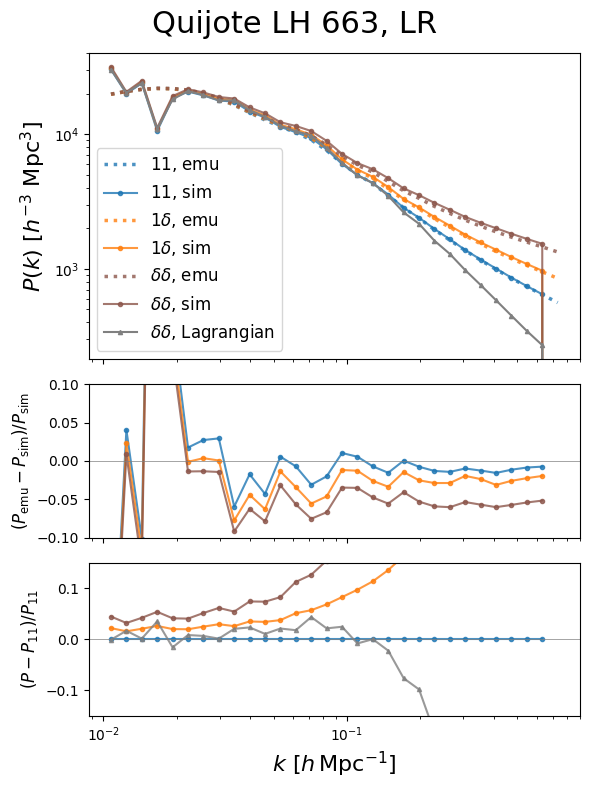

In [49]:
pnn_emu = pnn_emu_quijote
power_all_terms = power_all_terms_LR
pk_obj_delta = pk_obj_delta_LR
sim_name = f'Quijote LH {idx_LH}, LR'

#####

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
plt.suptitle(sim_name, fontsize=22)

alpha = 0.8

labels_pnn = utils.labels_pnn

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

i_pnn_compare = 0
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
# is_pnn_lag = [1]
# for i_pnn_lag in is_pnn_lag:
#     i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
i_pnn_corresponding = 5
label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
axarr[0].plot(pk_obj_delta_LR['k'], pk_obj_delta_LR['pk'], 
                marker='^', markersize=3, 
                label=label, color='grey')
axarr[2].plot(pk_obj_delta_LR['k'], 
                (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                marker='^', markersize=3, 
                ls='-', alpha=alpha, color='grey', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

/tmp/ipykernel_368305/2889015557.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_368305/2889015557.py:44: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_368305/2889015557.py:60: RuntimeWarning: invalid value encountered in divide
  (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


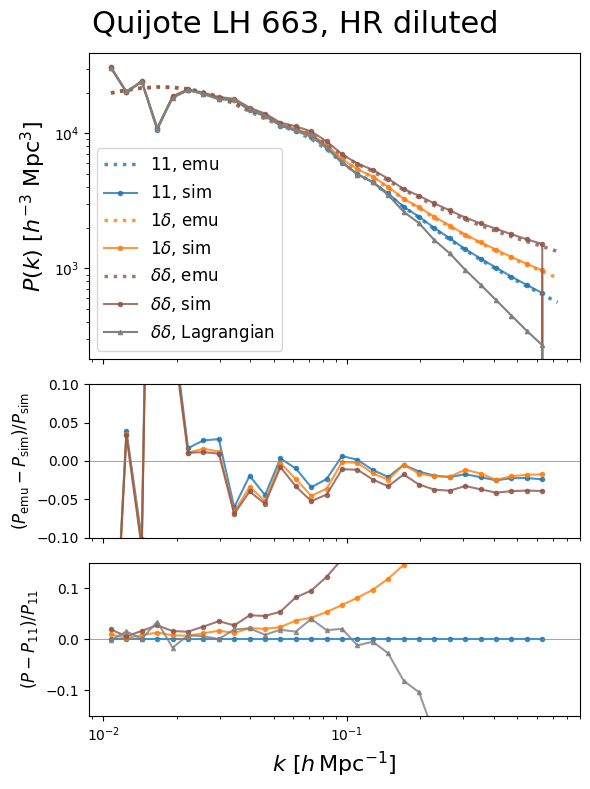

In [50]:
pnn_emu = pnn_emu_quijote
power_all_terms = power_all_terms_HRdil
pk_obj_delta = pk_obj_delta_HRdil
sim_name = f'Quijote LH {idx_LH}, HR diluted'

#####

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
plt.suptitle(sim_name, fontsize=22)

alpha = 0.8

labels_pnn = utils.labels_pnn

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

i_pnn_compare = 0
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
# is_pnn_lag = [1]
# for i_pnn_lag in is_pnn_lag:
#     i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
i_pnn_corresponding = 5
label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
axarr[0].plot(pk_obj_delta_LR['k'], pk_obj_delta_LR['pk'], 
                marker='^', markersize=3, 
                label=label, color='grey')
axarr[2].plot(pk_obj_delta_LR['k'], 
                (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                marker='^', markersize=3, 
                ls='-', alpha=alpha, color='grey', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

### Bacco results for comparison

In [53]:
sim_name_bacco = 'TheOne_N1536_L512'
tag_extra = ''
        
fn_pnn = f'../data/pnns/pnn_{sim_name_bacco}{tag_extra}.npy'
power_all_terms_bacco = np.load(fn_pnn, allow_pickle=True)
    
fn_pk_lag = f'../data/pks/pks_lagrangian_{sim_name_bacco}{tag_extra}.npy'
pk_objs_lag_bacco = np.load(fn_pk_lag, allow_pickle=True)  

In [56]:
from bacco.cosmo_parameters import TheOne as TheOne_dict   

if sim_name_bacco=='TheOne_N1536_L512':
    basedir = "/cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00"
snapnum_init = 0
halo_file_init = f"groups_{snapnum_init:03}/fof_subhalo_history_tab_orph_wweight_{snapnum_init:03}"
sim = bacco.Simulation(basedir=basedir, 
                    halo_file=halo_file_init,
                    )

expfactor_target = 1.0
diff = expfactor_target-sim.snaplist['a']
snapnum = sim.snaplist['snap'][np.argmin(diff[diff>0])]
expfactor = sim.snaplist['a'][np.argmin(diff[diff>0])]
print(snapnum, expfactor)
                                
cosmo_theone = bacco.Cosmology(**TheOne_dict, expfactor=expfactor)

2024-09-05 08:32:57,888 bacco.sims : Initialising simulation Default
2024-09-05 08:32:57,890 bacco.sims : try /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_000/fof_subhalo_history_tab_orph_wweight_000
2024-09-05 08:32:59,204 bacco.sims : Loading /cosmos_storage/cosmosims/MultiCosmology_N1536/power_N1536_L512.0_output/0.00/groups_000/fof_subhalo_history_tab_orph_wweight_000
2024-09-05 08:32:59,226 bacco.cosmo :    initialization took 0.000 secs
2024-09-05 08:32:59,302 bacco.sims : ...done in 1.34 s
2024-09-05 08:32:59,304 bacco.cosmo :    initialization took 0.000 secs


47 0.983014


In [57]:
kk = power_all_terms_bacco[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

cosmo_params_emu_theone = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_theone)
_, pnn_emu_theone = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_theone)

/tmp/ipykernel_368305/1745954031.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_368305/1745954031.py:44: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],
/tmp/ipykernel_368305/1745954031.py:59: RuntimeWarning: invalid value encountered in divide
  (pk_objs_lag[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


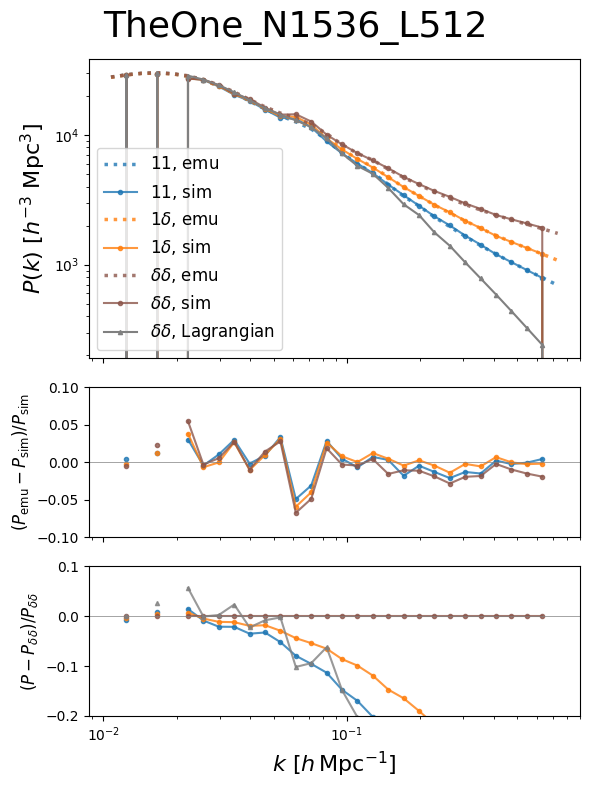

In [58]:
pnn_emu = pnn_emu_theone
power_all_terms = power_all_terms_bacco
pk_objs_lag = pk_objs_lag_bacco
sim_name = sim_name_bacco

#####

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
plt.suptitle(sim_name, fontsize=26)

alpha = 0.8

labels_pnn = utils.labels_pnn

color_pdd = 'C'+str(5)

k = kk
lw = 1.5
lw_emu = 2.5

i_pnn_compare = 5
pk_obj_compare = power_all_terms[i_pnn_compare]

is_pnn = [0,1,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    # mask = pk_obj['pk'] > 0
    # kk_emu = kk_emu[mask]
    # kk = kk[mask]
    # pk = pk_obj['pk'][mask]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=f'{labels_pnn[i_pnn]}, emu', 
                  ls=':', alpha=alpha, color=color, lw=lw_emu)
    axarr[0].plot(kk, pk_obj['pk'], 
                  ls='-', lw=lw, alpha=alpha, color=color,
                  marker='o', markersize=3, 
                  label=f'{labels_pnn[i_pnn]}, sim')
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                  marker='o', markersize=3, 
                  ls='-', lw=lw, alpha=alpha, color=color)
    axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  ls='-', lw=lw, 
                  marker='o', markersize=3, 
                  alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
is_pnn_lag = [1]
for i_pnn_lag in is_pnn_lag:
    i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
    label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
    axarr[0].plot(pk_objs_lag[i_pnn_lag]['k'], pk_objs_lag[i_pnn_lag]['pk'], 
                  marker='^', markersize=3, 
                  label=label, color='grey')
    axarr[2].plot(pk_objs_lag[i_pnn_lag]['k'], 
                  (pk_objs_lag[i_pnn_lag]['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                  marker='^', markersize=3, 
                  ls='-', alpha=alpha, color='grey', lw=lw)

# axarr[0].plot(pk_sdm['k'], pk_sdm['pk'], 
#            marker='d', markersize=3, 
#            color='k', alpha=alpha, ls='-.',lw=lw, label='P(k), SDM particles')
# axarr[2].plot(pk_sdm['k'],
#             (pk_sdm['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
#              marker='d', markersize=3, 
#              alpha=alpha, color='black',  ls='-.', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.2, 0.1)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')